# "Energy" and neural networks - Discrete Hopfield network  
# Constraint satisfaction problems

# Hand-wiring the constraints in a neural net.

How does one "sculpt the energy landscape"? One can use a form of Hebbian learning to dig holes (i.e. stable points or attractors) in the energy landscape indicating things to be remembered. Alternatively, one can study the nature of the problem to be solved and hand-wire the network to represent the constraints (i.e. reason out, or make an educated guess as to what the weights should be). 

We will follow the second approach to solve the correspondence problem. This problem crops up in a number of domains in pattern theory and recognition, and occurs whenever the features in two patterns need to be matched up, but one pattern is an unknown distortion of the other. Imagine, for example, the image of a face in memory, and you want to test whether an incoming stimulus is from the same person. Both patterns have more or less the same features, but they don't superimpose because they are from different views or expressions.  So you want to try to morph one on to the other, but before you do that, you might want to decide which features go with which--i.e. pupils to pupils, nostrils to nostrils, etc.. Establishing correspondences between two similar but not quite identical patterns has also been a central, and challenging problem in both stereo vision and motion processing.

In the next few sections, we will show how the weights in a network can be set up to represent constraints. Then we will look at three ways of letting the network evolve: asynchronous, synchronous, and partially asychronous  updating. The first case exactly satisfies the assumptions required for Hopfield's energy function.
    
This setup of the stereo problem is based on one of the earliest stereo algorithms from 1976. It is highly simplified.

# Establishing correspondences: An example of constraint satisfaction

# Introduction to stereo and the correspondence problem

If you cross your eyes so that you can perceptually fuse the two random patterns below, you may be able to see a small square floating in front of the random background. Crossing your eyes means that the left image goes to the right eye, and the right to the left. (Some people are better at looking at the left image with the left eye, and right with the right eye. For this type of human, the images below should be exchanged.)
This is an example of a random dot stereogram originally developed by Bela Julesz in the 1960's.

This is an example of a random dot stereogram originally developed by Bela Julesz in the 1960's.

In [1]:
# First initialize this notebook, load library for matrix manipulation and plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def imshowPatch(im):
    plt.imshow(im, cmap='gray', interpolation='none')
    plt.axis('off')

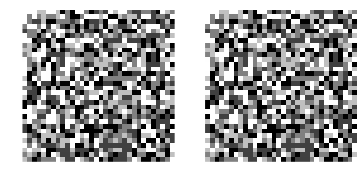

In [2]:
# Generate random dot stereogram, 32 x 32
# Make a randome image
# left = np.random.rand(32, 32)
# Discrete to four levels
left = np.random.randint(0, 5, size=(32,32)) / 4.0
# Shift a patch two pixels to right

r = [10, 10, 10, 10] # [x, y, w, h]
patch = left[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
right = left.copy()
# xoffset = 10
xoffset = 1; r[0] = r[0] + xoffset; # Move one pixel to the right
right[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = patch 
right[r[1]:r[1]+r[3], r[0]-xoffset:r[0]] = np.random.randint(0, 5, size=(r[3], xoffset)) / 4.0   # The hold is filled here

plt.subplot(121); imshowPatch(left)
plt.subplot(122); imshowPatch(right)

## Animation:

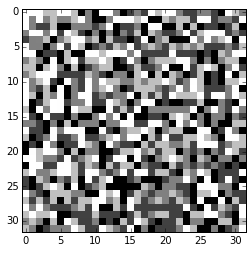

In [3]:
# Alternating the two images to show it's relly moving
import time
from IPython.display import display, clear_output
f, ax = plt.subplots()
for i in range(10):
    clear_output(wait=True); ax.imshow(left, cmap='gray', interpolation='none')
    display(f); time.sleep(0.1)
    clear_output(wait=True); ax.imshow(right, cmap='gray', interpolation='none')
    display(f); time.sleep(0.1)
clear_output()

It is made by taking a small square sub-patch in one image, shifting it by a pixel or two, to make the second image. Since the subpatch is shifted, it leaves a sub-column of pixels unspecified. These get assigned new random values.  

The stereogram mimics what happens in the real world when you look at an object that stands out in depth from a background--the left eye's view is slightly different than the right eye's view. The pixels for an object in front are shifted with respect to the background pixels in one eye's view compared to the other. There is a disparity between the two eyes. The distances between two points in the left eye and the distance of the images of the same two points in the right eye are, in general different, and depend on the relative depth of the two points in the world.

To see depth in a random dot stereogram, the human visual system effectively solves a correspondence problem. The fundamental problem is to figure out which of the pixels in the left eye belong to which ones in the right. This is a non-trivial computational problem when so may of the features (i.e. the pixel intensities) look the same--there is considerable potential for false matches.  A small minority don't have matching pairs (i.e. the ones that got filled in the vertical slot left after shifting the sub-patch). We'll get to this in a moment, but first let's make a stereogram using Mathematica.

Human perception solves the stereo correspondence, so let us see if we can devise a neural network style algorithm to solve it. 

# Display a pair of images

It is not easy to fuse the left and right image without a stereo device (it requires placing the images side by side and crossing your eyes. We can check out our images another way.

The visual system also solves a correspondence problem over time. We can illustrate this using ListAnimate[]. By slowing it down, you can find a speed in which the central patch almost magically appears to oscillate and float above the the background. If you stop the animation (click on ||), the central square patch disappears again into the camouflage.

# Two-state neural network  implementation using Marr and Poggio (1976) constraints

## Simplify the problem to one dimension

We will apply the constraints proposed by Marr and Poggio (1976) to try to solve the correspondence problem for just the middle rows of twoDlefteye and twoDrighteye:

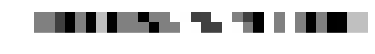

In [4]:
leftMiddle = np.matrix(left[16,])
rightMiddle = np.matrix(right[16,])
imshowPatch(np.concatenate((leftMiddle, rightMiddle)))

We've displayed the left eye's view above the right eye's, so you can try to spot which pixels have been shifted. Because the patch was shifted horizontally, we haven't lost the essence of the correspondence problem by reducing it to one dimension. You can see the ambiguity in the correspondence problem.

Following Marr and Poggio, we will try to solve the correspondence (i.e. which pairs of pixels in the two images belong together) using three constraints: 

- compatibility
- uniqueness
- smoothness

We will see what these constraints mean as we move along. The challenge is to design a network that  enforces these constraints.

## The compatibility constraint

The compatibility constraint says that similar features in each eye should match, in other words like pixels (same graylevel) in each image should match. We can represent compatibility by constructing a "compatibility matrix" which has a 1 at each location where there is a possible match (i.e. in graylevel color), and zeros elsewhere.

Here's the plot of the compatibility of the middle row (size/2) for the left and right eye's stereo pictures, where black represents 1 (compatible), and white 0 (not compatible). 

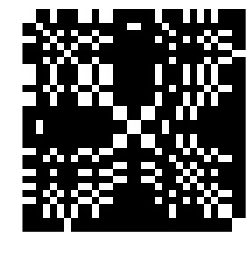

In [5]:
leftRepeat = np.repeat(leftMiddle, 32, axis=0)
rightRepeat = np.repeat(rightMiddle.T, 32, axis=1)
compatibility = (leftRepeat == rightRepeat)
imshowPatch(compatibility)

# The uniqueness and smoothness constraints

But many of these possible matches seem unlikely. A given point in one eye shouldn't have lots of matches in the other eye--a point on a surface in the world typically maps to at most one point in each eye. We would like to find a line through the compatibility matrix to indicate unique matches. So we have to discourage more than one unit from being on in any given row or column (i.e. enforce a uniqueness constraint).

Also when we think about how features along surfaces typically change as a function of position, we realize that surfaces to a first approximation are smooth--thus, nearby points on a surface project to nearby points in the two eyes. For convenience, let's assume an even stronger constraint in which nearby points have constant disparities. (Recall that disparity refers to the relative shift of corresponding points in the two images.)


This means to we should encourage elements that have nearest neighbor support along the diagonals to be on (to encourage regions that have constant disparity). This latter constraint is called a "surface smoothness constraint", which refers to the underlying assumption that changes in depth usually change gradually--sudden changes in disparity are rare. 

We will follow Marr and Poggio and set up a threshold logic unit at each location of the compatibility matrix, and wire each up to reflect the above constraints. We are going to have to worry about the boundaries. There are several ways of doing this. One is to have a "free" boundary in which the connection weights at the boundaries are actually different (to compensate for a lack of neighbors in the other directions). Although not biologically realistic, a second way is to use a toroidal geometry, restricting indices by the following modulus function: myMod[x_] := Mod[x-1,size]+1. This option is computationally convenient and makes it possible to comply with the restriction of symmetric connections everywhere. 

To encourage uniqueness, let's make the vertical and horizontal connection weights all equal and negative with a weight inhib. To encourage smoothness, we'll make the diagonal support positive with mutally excitatory weights excit. The network will have biases for each unit (which are equivalent to appropriate thresholds for each unit) proportional to the original compatibility matrix. These biases correspond to the Ui's in the Hopfield net and serve to prevent the network from loosing this strong constraint from the data as the iterations progress. 

Note that we won't  set up the network calculations using a matrix and matrix multiplications as you will do in the Hopfield memory examples. This is because most of our connections are zero and we don't want to waste time multiplying zero elements and adding them up. So the code below will look messier.

# Hopfield Net: Asynchronous updating--all sites visited randomly, at random times

(Animation)

To do  random asynchronous updating, you simply pick a site at random and update it, and then pick another, and so on.

In [6]:
excitWeight = 2
inhibWeight = -1
theta = 13
k = 8
V = compatibility.copy()

def r(ind):
    return ind % 32

for iter in range(10000):
    p = np.random.randint(32, size=(1,2))
    x0 = p[0,0]; y0 = p[0,1]
    # sum over the same row
    inhib = 0
    for x in range(-4, 5):
        inhib = inhib + V[y0, r(x0+x)]
        
    # sum over the same col
    for y in range(-4, 5):
        inhib = inhib + V[r(y0+y), x0]
    inhib = inhib - 2 * V[y0, x0]
    
    # sum over diagonal
    excit = 0
    for off in range(-4, 5):
        excit = excit + V[r(y0+off), r(x0+off)]

    excit = excit - V[y0,x0]

    V[y0, x0] = (inhibWeight * inhib + excitWeight * excit + k * V[y0,x0] > theta)

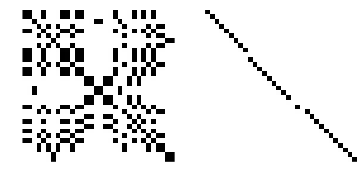

In [7]:
plt.subplot(121); imshowPatch(-compatibility)
plt.subplot(122); imshowPatch(-V)

# Energy and constraint satisfaction

What use is energy?

We haven't computed the Hopfield energy for each iteration. But we could, and in fact this calculation can be useful. 

In our toy example of a random dot stereogram, we know the answer (we made the stereogram), so computation of the energy of the final stable state can be compared with the energy of the right answer. If the right answer has a lower energy than the stable state reached, we know we got stuck in a local minimum. If the right answer has a higher energy, then the constraints must have been set up incorrectly. Energy can be a useful number to calculate during network model development.